# Why overfitting occurs?

According to statistical learning theory for all **reasonable machine learning methods** training and test errors converge to the true risk when the number of training samples grows. However, the convergence speeds really depends on many factors. The following notebook highlights the differences and causes behind them.    

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd

from pandas import Series
from pandas import DataFrame
from pandas import melt
from typing import List

from numpy.random import choice
from numpy.random import uniform
from scipy.stats import binom

# Local imports
from convenience import mdisplay
from convenience import combine_categories

from plotnine import *
from plotnine import options

## I. Theoretical setup

In the lecture, we argued that training error behaves differently from test error as the training process systematically chooses functions for which the empirical risk estimate underestimates the risk. We also argued that the trainig process does not test all functions that can be represented by the machine learning method and thus convergence is faster than could be inferred from the total number of reachable functions. Clearly, the gradient decent check functions that are greated during iterations 
\begin{align*}
\mathbf{w}_{i+1} =\mathbf{w}_i - \eta_i\cdot \nabla f\enspace.
\end{align*}
However, it not so simple as by computing the gradient and making an step to opposite direction the learning algorithm also implicitly check empirical risk estimates of many functions that are in the surrounding of $\boldsymbol{w}_i$. What functions are extremely difficult to discuss with out delving into details of advanced calculus. Hence, we illustrate this effect empirically by trying different epoch sizes and comparing the results.  

**Data distributions:**
For simplicity, the input data will be randomly sampled form the set $\{0,1\}^k$, i.e., we need to predict the class from $k$ independent binary features $x_1,x_2,\ldots, x_k\in\{0,1\}$. The target class $y\in\{0,1\}$ will be sampled by flipping a coin with the bias $\alpha\in[0,1]$. 


## II. The simplest example

* Let us consider a one-dimensional input space $x_1\in\{0,1\}$ with a random class label $y\in\{0,1\}$. 
* Consider the learning task where the training algorithm has to choose between two functions $f_0(x_1)\equiv 0$ and $f_1(x)\equiv 1$.
* The only sound choice without background information is to choose the function with minimal empirical risk $R_N(f)$.

In [2]:
def data_gen(n: int):
    return DataFrame({'x': choice([0,1], size=n, replace=True) , 'y': choice([0,1], size=n, replace=True) })   

def f0(x):
    return [0] * len(x)

def f1(x):
    return [1] * len(x)

def empirical_risk(data, f):
    yhat = f(data['x'])
    return np.mean(yhat != data['y'])

In [3]:
data = (data_gen(3)
        .assign(f0=lambda df: f0(df['x']))
        .assign(f1=lambda df: f1(df['x'])))

display(data)
print(f'Empirical risk of f0: {empirical_risk(data, f0):.2f}')
print(f'Empirical risk of f1: {empirical_risk(data, f1):.2f}')

,x,y,f0,f1
0,1,1,0,1
1,0,1,0,1
2,0,1,0,1


Empirical risk of f0: 1.00
Empirical risk of f1: 0.00


**Expected ranges for empirical risk:** If the training set contains $n$ elements then it is straightforward to compute 95% **prediction intervals** for the empirical risks of $R_n(f)$ for $f_0$ and $f_1$. As the label $y$ is independent form the input $\boldsymbol{x}$, we can compute these bounds from using the quantiles of Bernulli distribution.

In [4]:
def prediction_interval(n: int, prob: float = 0.95):
    return [binom.ppf(0.5 * (1 - prob), n=n, p=0.5)/n, binom.ppf(1 - 0.5 * (1 - prob), n=n, p=0.5)/n] 

prediction_interval(10)

[0.2, 0.8]

Now we can do the experiment and collect the estimates of empirical risks for training set of size 100.

In [5]:
n = 100
k = 100
y_0, y_1 = prediction_interval(n)

emp_risk = DataFrame(None, index=range(10), columns=['$f_0$', '$f_1$', 'winner'])

for i in range(k):
    data = data_gen(n)
    emp_risk.loc[i, '$f_0$'] = empirical_risk(data, f0)
    emp_risk.loc[i, '$f_1$'] = empirical_risk(data, f1)
    emp_risk.loc[i, 'winner'] = '$f_0$' if emp_risk.loc[i, '$f_0$'] < emp_risk.loc[i, '$f_1$'] else '$f_1$'

display(emp_risk.head())

,$f_0$,$f_1$,winner
0,0.56,0.44,$f_1$
1,0.5,0.5,$f_1$
2,0.57,0.43,$f_1$
3,0.44,0.56,$f_0$
4,0.47,0.53,$f_0$


In [6]:
sdf = melt(emp_risk, id_vars=['winner'], var_name='function', value_name='emp_risk')
sdf['emp_risk'] = sdf['emp_risk'].astype(float)

sdf['type'] = 'Good approximator'
sdf.loc[sdf['emp_risk'] <= y_0, 'type'] = 'Lower outlier'
sdf.loc[sdf['emp_risk'] >= y_1, 'type'] = 'Upper outlier'
sdf['winner'] = sdf['winner'] == sdf['function']

display(sdf.head())

,winner,function,emp_risk,type
0,False,$f_0$,0.56,Good approximator
1,False,$f_0$,0.50,Good approximator
2,False,$f_0$,0.57,Good approximator
3,True,$f_0$,0.44,Good approximator
4,True,$f_0$,0.47,Good approximator


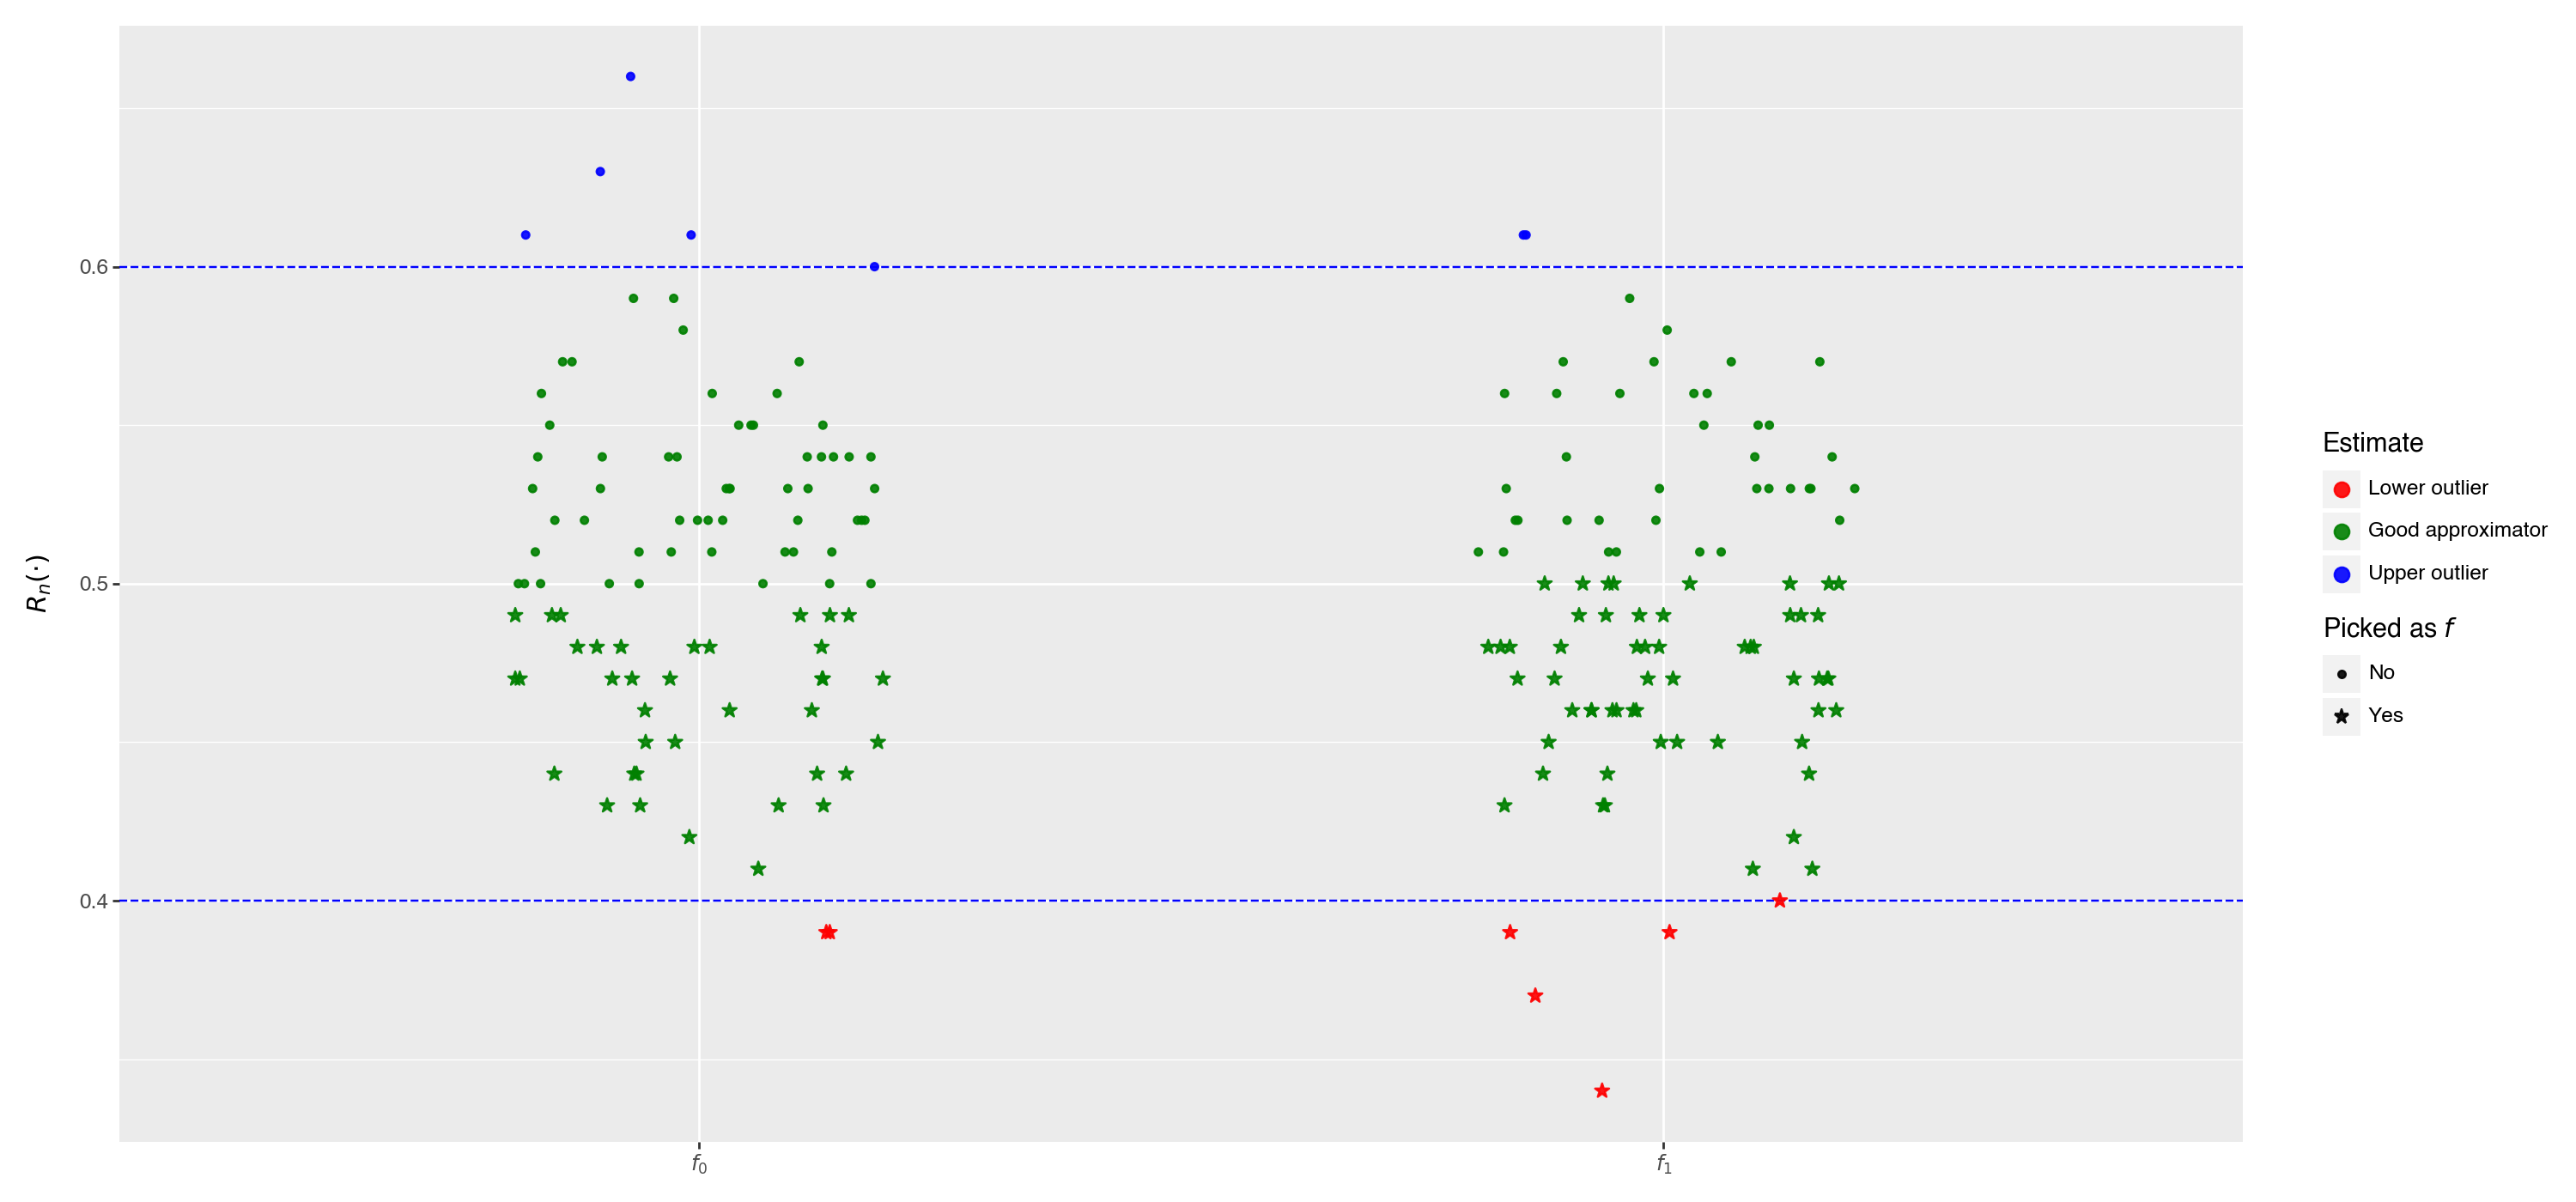

In [7]:
options.figure_size = (15, 7)
p  = ggplot(sdf)
p += geom_hline(yintercept=y_0, linetype='dashed', color='blue')
p += geom_hline(yintercept=y_1, linetype='dashed', color='blue')
p += geom_jitter(aes(x='function', y='emp_risk', color='type', shape='winner'), 
                 size=3, width=0.2, height=0, alpha=0.9) 
p += scale_color_manual(
    name = 'Estimate',
    values=['red', 'green', 'blue'], 
    breaks=['Lower outlier', 'Good approximator', 'Upper outlier']) 
p += scale_shape_manual(
    name = 'Picked as $f$',
    values = ['.', '*'],
    breaks = [False, True],
    labels = ['No', 'Yes']
)
p += xlab('') + ylab('$R_n(\cdot)$')
display(p)
# p.save('empirical_risk_and_learning.pdf', path='../results', verbose=False)

**Judgement:** The training error remains is above $0.4$ only if the empirical error of $f_0$ stays in the range 
$[0.4, 0.6]$  as $R_N(f_0)+R_N(f_1)=1$ and we always pick the function with the smaller empirical error. The corresponding probability is twice as larger than the probability $\Pr[R_N(f)\geq 0.4]$ since both tails matter. 

## III. Bayes-optimal solution for one-dimensional unpredicatble case

* Let us consider a one-dimensional input space $x_1\in\{0,1\}$ with a random class label $y\in\{0,1\}$.
* Consider the learning task where the training algorithm has to choose between all possible functions $f:\{0,1\}\to\{0,1\}$.
* The only sound choice without background information is to choose the function with minimal empirical risk $R_N(f)$.

In [8]:
def f00(x):
    return [0] * len(x)

def f01(x):
    return (x == 1).astype(int)

def f10(x):
    return (x == 0).astype(int)

def f11(x):
    return [1] * len(x)

In [9]:
data = (DataFrame({'x': [0,0, 1,1], 'y': [0,1,0,1]})
        .assign(f00=lambda df: f00(df['x']))
        .assign(f01=lambda df: f01(df['x']))
        .assign(f10=lambda df: f10(df['x']))
        .assign(f11=lambda df: f11(df['x'])))
data

,x,y,f00,f01,f10,f11
0,0,0,0,0,1,1
1,0,1,0,0,1,1
2,1,0,0,1,0,1
3,1,1,0,1,0,1


Now we can do the experiment and collect the estimates of empirical risks for training set of size 100.

In [10]:
n = 100
k = 100
y_0, y_1 = prediction_interval(n)

emp_risk = DataFrame(None, index=range(10), columns=['$f_{00}$', '$f_{01}$', '$f_{10}$', '$f_{11}$', 'winner'])

for i in range(k):
    data = data_gen(n)
    emp_risk.loc[i, '$f_{00}$'] = empirical_risk(data, f00)
    emp_risk.loc[i, '$f_{01}$'] = empirical_risk(data, f01)
    emp_risk.loc[i, '$f_{10}$'] = empirical_risk(data, f10)
    emp_risk.loc[i, '$f_{11}$'] = empirical_risk(data, f11)
     
emp_risk['winner'] = emp_risk.idxmin(axis=1)

display(emp_risk.head())

,$f_{00}$,$f_{01}$,$f_{10}$,$f_{11}$,winner
0,0.49,0.5,0.5,0.51,$f_{00}$
1,0.5,0.51,0.49,0.5,$f_{10}$
2,0.46,0.52,0.48,0.54,$f_{00}$
3,0.38,0.41,0.59,0.62,$f_{00}$
4,0.49,0.45,0.55,0.51,$f_{01}$


In [11]:
sdf = melt(emp_risk, id_vars=['winner'], var_name='function', value_name='emp_risk')
sdf['emp_risk'] = sdf['emp_risk'].astype(float)

sdf['type'] = 'Good approximator'
sdf.loc[sdf['emp_risk'] <= y_0, 'type'] = 'Lower outlier'
sdf.loc[sdf['emp_risk'] >= y_1, 'type'] = 'Upper outlier'
sdf['winner'] = sdf['winner'] == sdf['function']

display(sdf.head())

,winner,function,emp_risk,type
0,True,$f_{00}$,0.49,Good approximator
1,False,$f_{00}$,0.50,Good approximator
2,True,$f_{00}$,0.46,Good approximator
3,True,$f_{00}$,0.38,Lower outlier
4,False,$f_{00}$,0.49,Good approximator


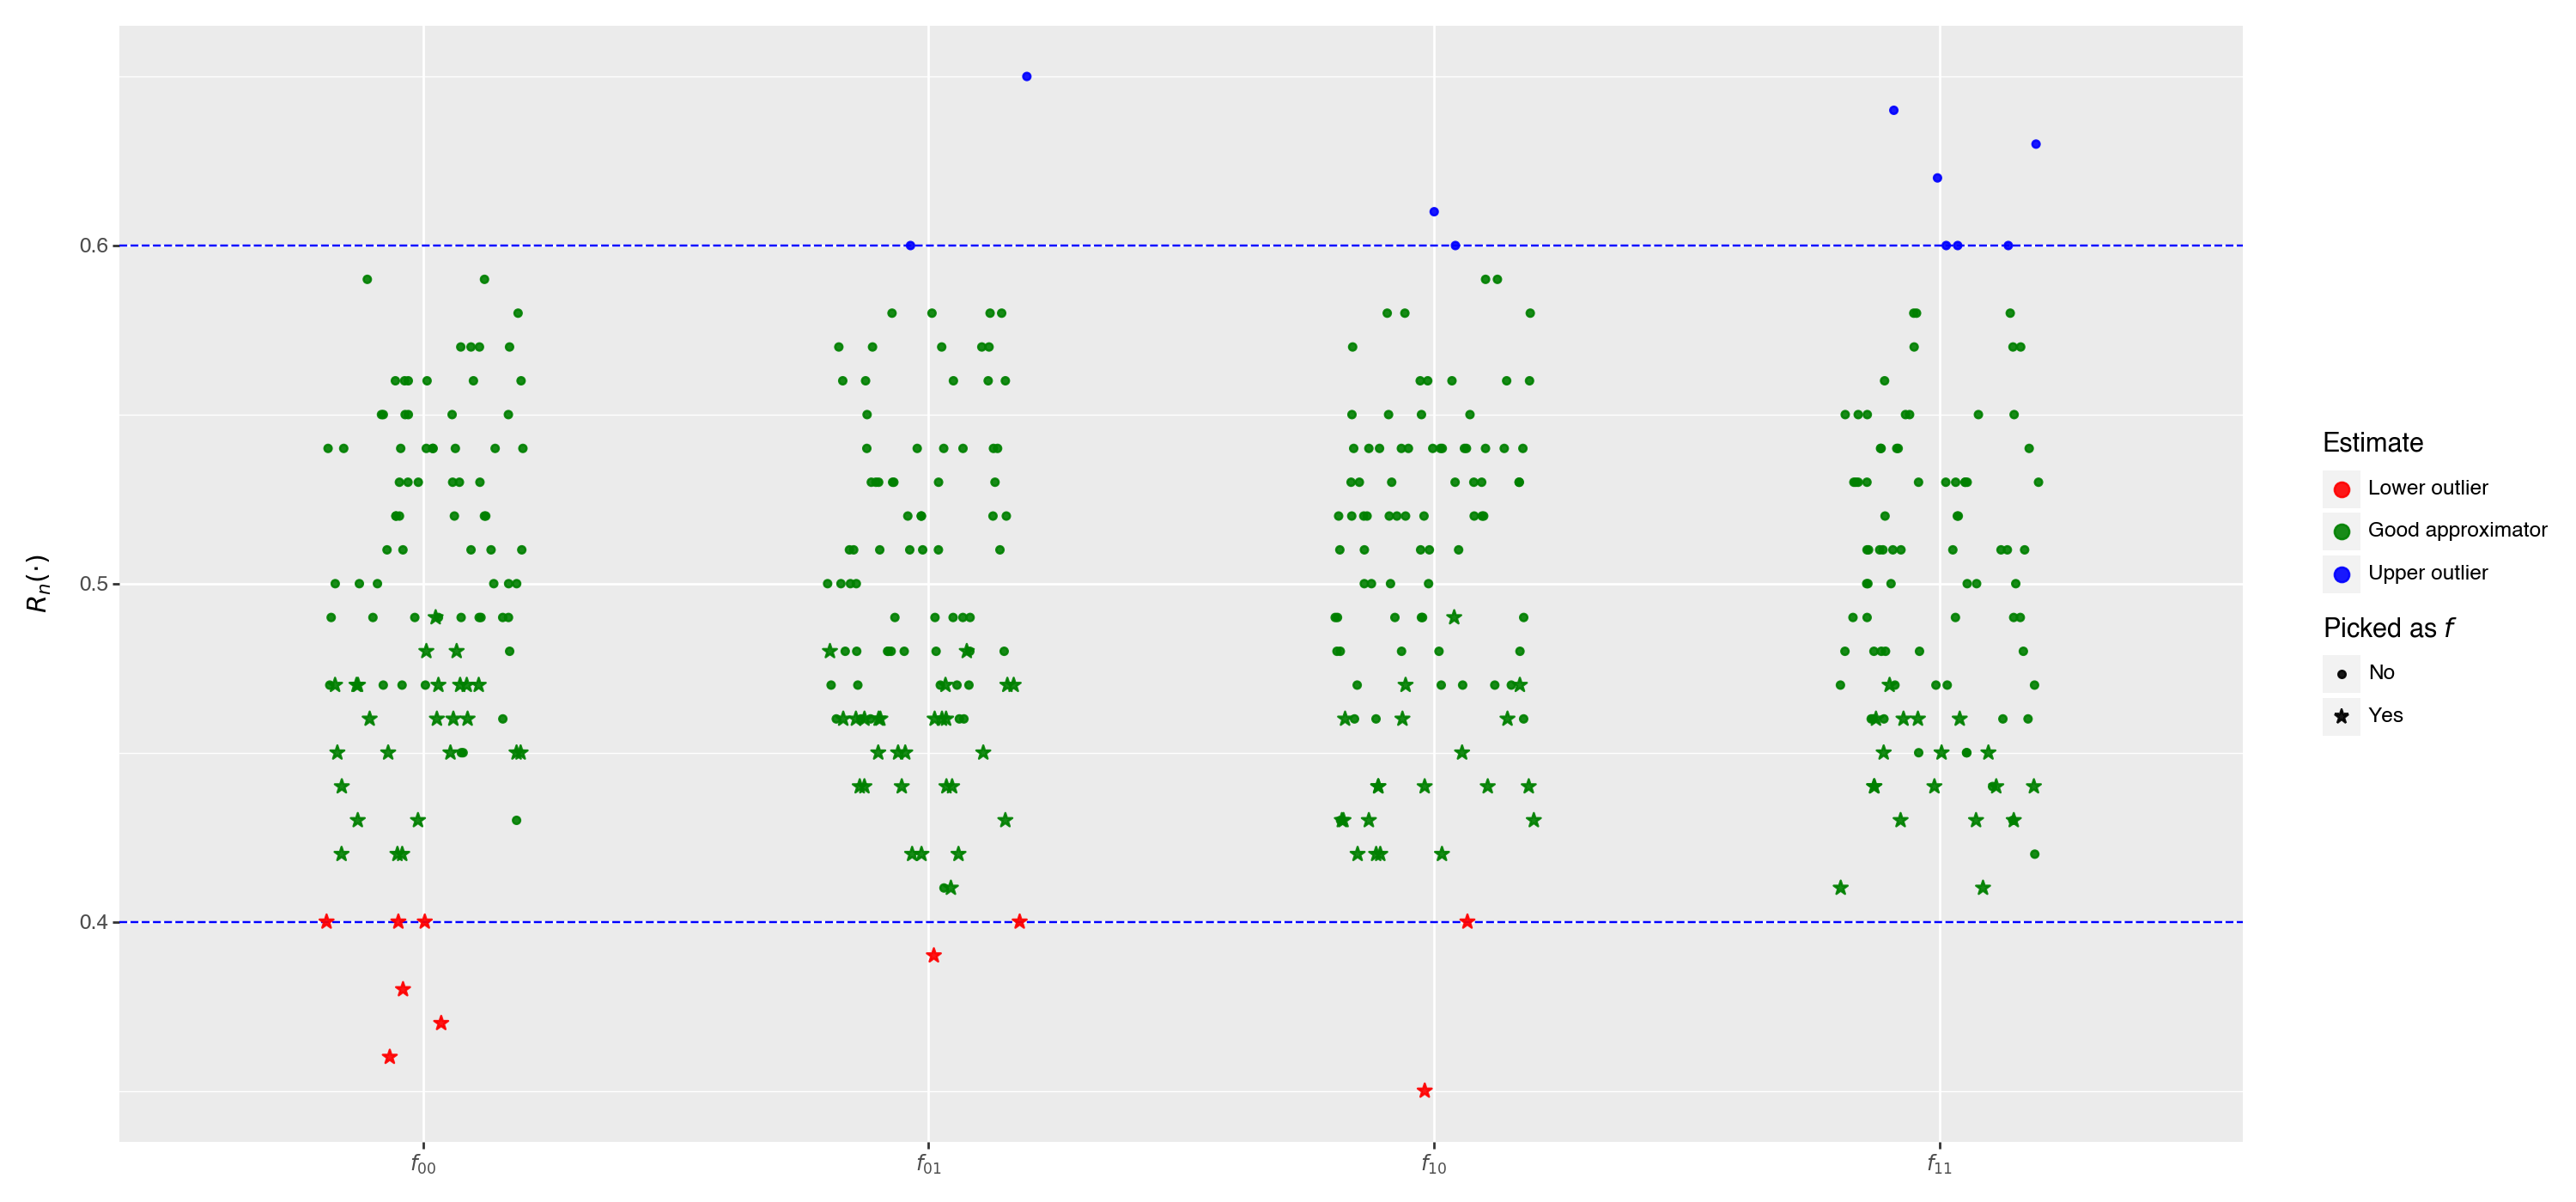

In [12]:
options.figure_size = (15, 7)
p  = ggplot(sdf)
p += geom_hline(yintercept=y_0, linetype='dashed', color='blue')
p += geom_hline(yintercept=y_1, linetype='dashed', color='blue')
p += geom_jitter(aes(x='function', y='emp_risk', color='type', shape='winner'), 
                 size=3, width=0.2, height=0, alpha=0.9) 
p += scale_color_manual(
    name = 'Estimate',
    values=['red', 'green', 'blue'], 
    breaks=['Lower outlier', 'Good approximator', 'Upper outlier']) 
p += scale_shape_manual(
    name = 'Picked as $f$',
    values = ['.', '*'],
    breaks = [False, True],
    labels = ['No', 'Yes']
)
p += xlab('') + ylab('$R_n(\cdot)$')
display(p)

**Judgement:** Now the discrepacy between single function failure probability  $\Pr[R_N(f)\geq 0.4]$ and the actual probability that the minimal of all four empirical risk estimates are inside brackets is even bigger, since there are four estimates that can violate our goal. Although events $R_N(f_{00})\geq 0.4$, $R_N(f_{01})\geq 0.4$, $R_N(f_{10})\geq 0.4$ and $R_N(f_{11})\geq 0.4$ are not mutually exclusive, the the best general bound to failure probabilities still union bound. This means that convergence speed is much lower.

## IV. Bayes-optimal solution for a one-dimensional case with biased coin

* Let us consider a one-dimensional input space $x_1\in\{0,1\}$ with a random class label $y$ that is set 1 with probability $\alpha=0.9$.
* Consider the learning task where the training algorithm has to choose between all possible functions $f:\{0,1\}\to\{0,1\}$.
* The only sound choice without background information is to choose the function with minimal empirical risk $R_N(f)$.

Now it is straightforward to compute true risk for all four functions. Let us build a function that computes it for all possible bias values.

In [13]:
def true_risk(f, alpha=0.5):
    yp = f(np.array([0,1]))
    # This is just a covoluted way to express that prediction is wrong for f(i) 
    return 0.5 * sum(alpha**(1 - yp[i])*(1 - alpha)**(yp[i]) for i in range(2))

print(f'The best function f11 achieves risk {true_risk(f11, alpha=0.9):0.1f} as expected')

The best function f11 achieves risk 0.1 as expected


It is also straightforward to compute prediction intervals for the different levels of risk. 
* Remember that risk in our context is a probability $R$ that function gives out incorrect prediction.
* Empirical risk estimation is thus just draw on $N$ coins with probability $\Pr[L_i=1]=R$.

In [14]:
def prediction_interval_for_biased_coin(n: int, bias: float=0.5,  prob: float = 0.95):
    return [binom.ppf(0.5 * (1 - prob), n=n, p=bias)/n, binom.ppf(1 - 0.5 * (1 - prob), n=n, p=bias)/n] 

assert prediction_interval_for_biased_coin(10, 0.5) == prediction_interval(10)
assert prediction_interval_for_biased_coin(100, 0.5) == prediction_interval(100)

Finally, we need to modify the data generator to accomodate the new distribution.  

In [15]:
def data_gen_with_bias(n: int, bias: float=0.5):
    return DataFrame({'x': choice([0,1], size=n, replace=True) , 'y': (uniform(0.0, 1.0, size=n) <= bias).astype(int)})   

In [16]:
n = 100
k = 100
alpha = 0.9

emp_risk = DataFrame(None, index=range(10), columns=['$f_{00}$', '$f_{01}$', '$f_{10}$', '$f_{11}$', 'winner'])

for i in range(k):
    data = data_gen_with_bias(n, alpha)
    emp_risk.loc[i, '$f_{00}$'] = empirical_risk(data, f00)
    emp_risk.loc[i, '$f_{01}$'] = empirical_risk(data, f01)
    emp_risk.loc[i, '$f_{10}$'] = empirical_risk(data, f10)
    emp_risk.loc[i, '$f_{11}$'] = empirical_risk(data, f11)
     
emp_risk['winner'] = emp_risk.idxmin(axis=1)

display(emp_risk.head())

,$f_{00}$,$f_{01}$,$f_{10}$,$f_{11}$,winner
0,0.95,0.52,0.48,0.05,$f_{11}$
1,0.94,0.45,0.55,0.06,$f_{11}$
2,0.83,0.49,0.51,0.17,$f_{11}$
3,0.89,0.54,0.46,0.11,$f_{11}$
4,0.92,0.44,0.56,0.08,$f_{11}$


In [17]:
sdf = melt(emp_risk, id_vars=['winner'], var_name='function', value_name='emp_risk')
sdf['emp_risk'] = sdf['emp_risk'].astype(float)

# Lets define true risk and corresponding prediction interval
sdf['fun_index'] = sdf['function'].str[4:6]
sdf['true_risk'] = sdf['fun_index'].map(lambda x: true_risk(eval(f'f{x}'), alpha))
sdf['prediction_interval'] = sdf['true_risk'].map(lambda x: prediction_interval_for_biased_coin(n, x, prob=0.95))

# Lets label points
sdf['type'] = 'Good approximator'
sdf.loc[sdf['emp_risk'] <= sdf['prediction_interval'].map(lambda x: x[0]), 'type'] = 'Lower outlier'
sdf.loc[sdf['emp_risk'] >= sdf['prediction_interval'].map(lambda x: x[1]), 'type'] = 'Upper outlier'
sdf['winner'] = sdf['winner'] == sdf['function']

In [18]:
display(sdf.head())

,winner,function,emp_risk,fun_index,true_risk,prediction_interval,type
0,False,$f_{00}$,0.95,00,0.9,"[0.84, 0.95]",Upper outlier
1,False,$f_{00}$,0.94,00,0.9,"[0.84, 0.95]",Good approximator
2,False,$f_{00}$,0.83,00,0.9,"[0.84, 0.95]",Lower outlier
3,False,$f_{00}$,0.89,00,0.9,"[0.84, 0.95]",Good approximator
4,False,$f_{00}$,0.92,00,0.9,"[0.84, 0.95]",Good approximator


In [19]:
borders = DataFrame({'fun_index': ['00', '01', '10', '11']})
borders['function'] = '$f_{' + borders['fun_index'] +'}$'
borders['true_risk'] = borders['fun_index'].map(lambda x: true_risk(eval(f'f{x}'), alpha))
borders['p025'] = borders['true_risk'].map(lambda x: prediction_interval_for_biased_coin(n, x, prob=0.95)[0])
borders['p975'] = borders['true_risk'].map(lambda x: prediction_interval_for_biased_coin(n, x, prob=0.95)[1])
borders['p001'] = borders['true_risk'].map(lambda x: prediction_interval_for_biased_coin(n, x, prob=0.998)[0])
borders['p999'] = borders['true_risk'].map(lambda x: prediction_interval_for_biased_coin(n, x, prob=0.998)[1])

In [20]:
borders

,fun_index,function,true_risk,p025,p975,p001,p999
0,00,$f_{00}$,0.9,0.84,0.95,0.80,0.98
1,01,$f_{01}$,0.5,0.40,0.60,0.35,0.65
2,10,$f_{10}$,0.5,0.40,0.60,0.35,0.65
3,11,$f_{11}$,0.1,0.05,0.16,0.02,0.20


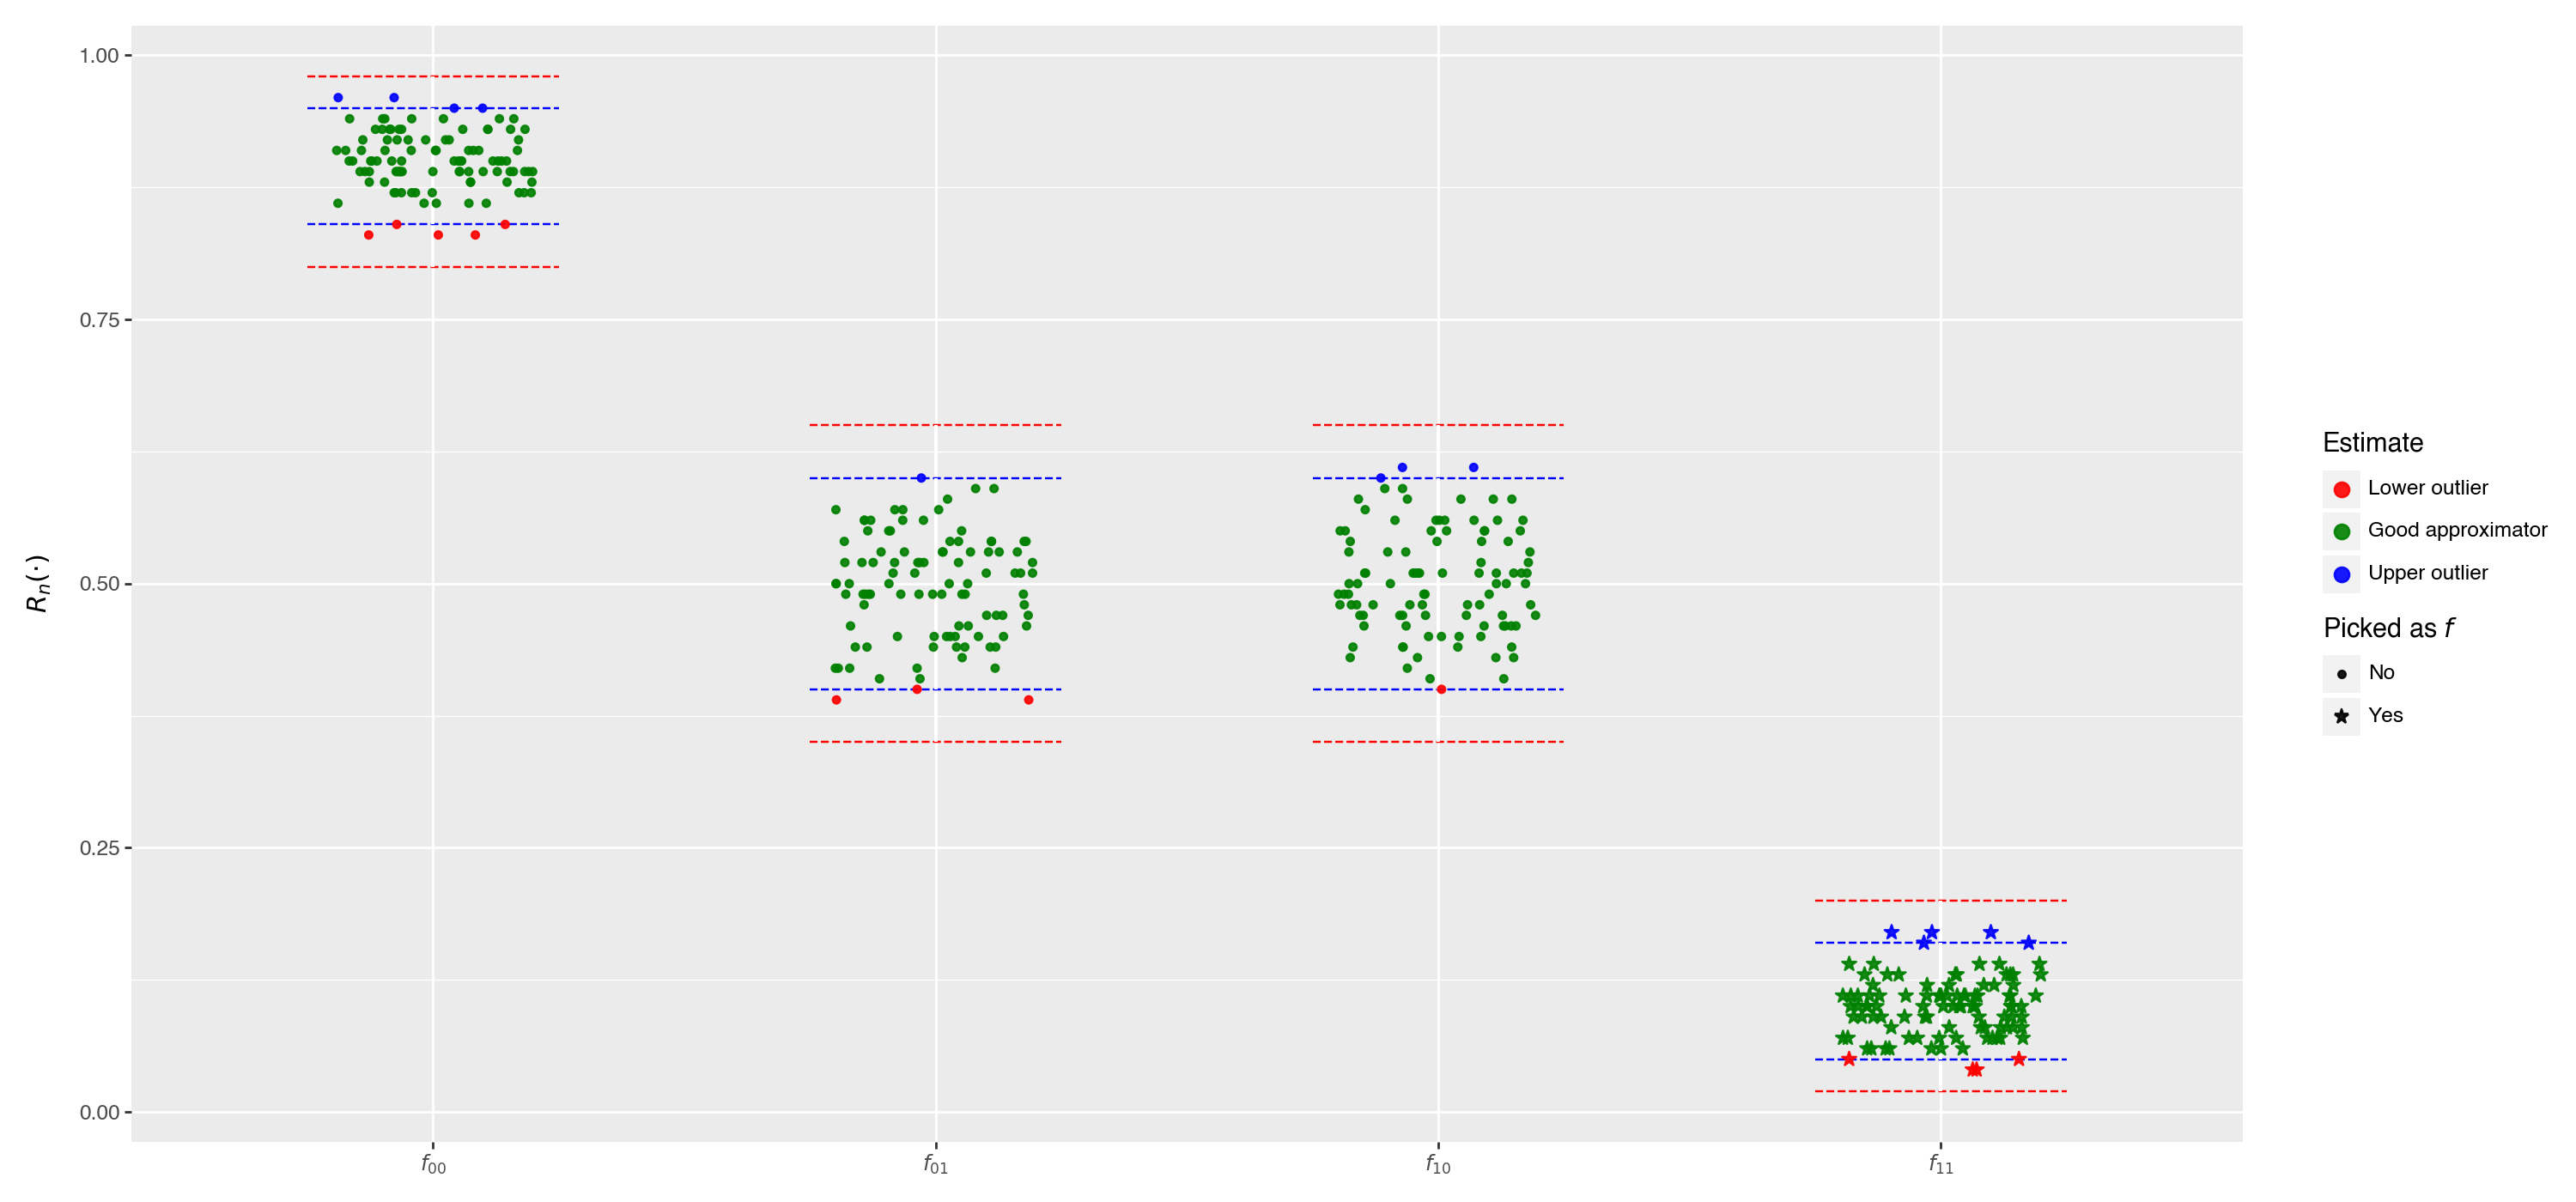

In [21]:
options.figure_size = (15, 7)
p  = ggplot(sdf)
p += geom_errorbar(aes(x='function',  ymin='p001', ymax='p999'), data=borders, color='red', linetype='dashed')
p += geom_linerange(aes(x='function',  ymin='p001', ymax='p999'), data=borders, color='white', linetype='solid', size=0.8)
p += geom_errorbar(aes(x='function',  ymin='p025', ymax='p975'), data=borders, color='blue', linetype='dashed')
p += geom_linerange(aes(x='function',  ymin='p025', ymax='p975'), data=borders, color='white', linetype='solid',size=0.8)

p += geom_jitter(aes(x='function', y='emp_risk', color='type', shape='winner'), 
                 size=3, width=0.2, height=0, alpha=0.9) 
p += scale_color_manual(
    name = 'Estimate',
    values=['red', 'green', 'blue'], 
    breaks=['Lower outlier', 'Good approximator', 'Upper outlier']) 
p += scale_shape_manual(
    name = 'Picked as $f$',
    values = ['.', '*'],
    breaks = [False, True],
    labels = ['No', 'Yes']
)
p += xlab('') + ylab('$R_n(\cdot)$')
display(p)

**Judgements:** 
* If one function has a much smaller risk, then the lower outliers from other functions do not reach event the upper 95% prediction interval of the optimal function $f_*$. Note that red 99.8% prediction intervals are much higher than blue 95% prediction intervals for the optimal function.
*  As a consequence, the failure probability is completely dominated by the probability that $R_N(f_*)$ is below its 2.5% prediction line and the training error converges as fast as the test error.
*  Of course, this is abnormal situation but in general a large set of potential functions can be elliminated from the consideration. That is, the universal **union bound** estimate is **very conservative** if the problem is learnable.  

## V. Continuous parametrisation in one-dimensional case

It is straightforward to see that all functions can be obtained as linear combinations $\beta_0 f_{10}+\beta_1 f_{01}$ for $\beta_0,\beta_1\in\{0,1\}$. To simplify the optimisation task, one can relax the problem and seek a solution for real   $\beta_0,\beta_1\in[0,1]$. To get integer predictions we must define
\begin{align*}
f_{\beta_0,\beta_1}(x)=\mathrm{round}(\beta_0 f_{10}+\beta_1 f_{01})\enspace.
\end{align*}
One can naively think that we now have an infinite number of prediction intervals to consider and thus we cannot bound the failure probability
$\Pr[R_N(f_*)\leq R(f_*)-\varepsilon]$ for a function $f_*$ that minimises the empirical risk. But his is not the case:
* We  still have effectively only four possible prediction functions.
* Entire search space decomposes into regions that always the same empirical risk.

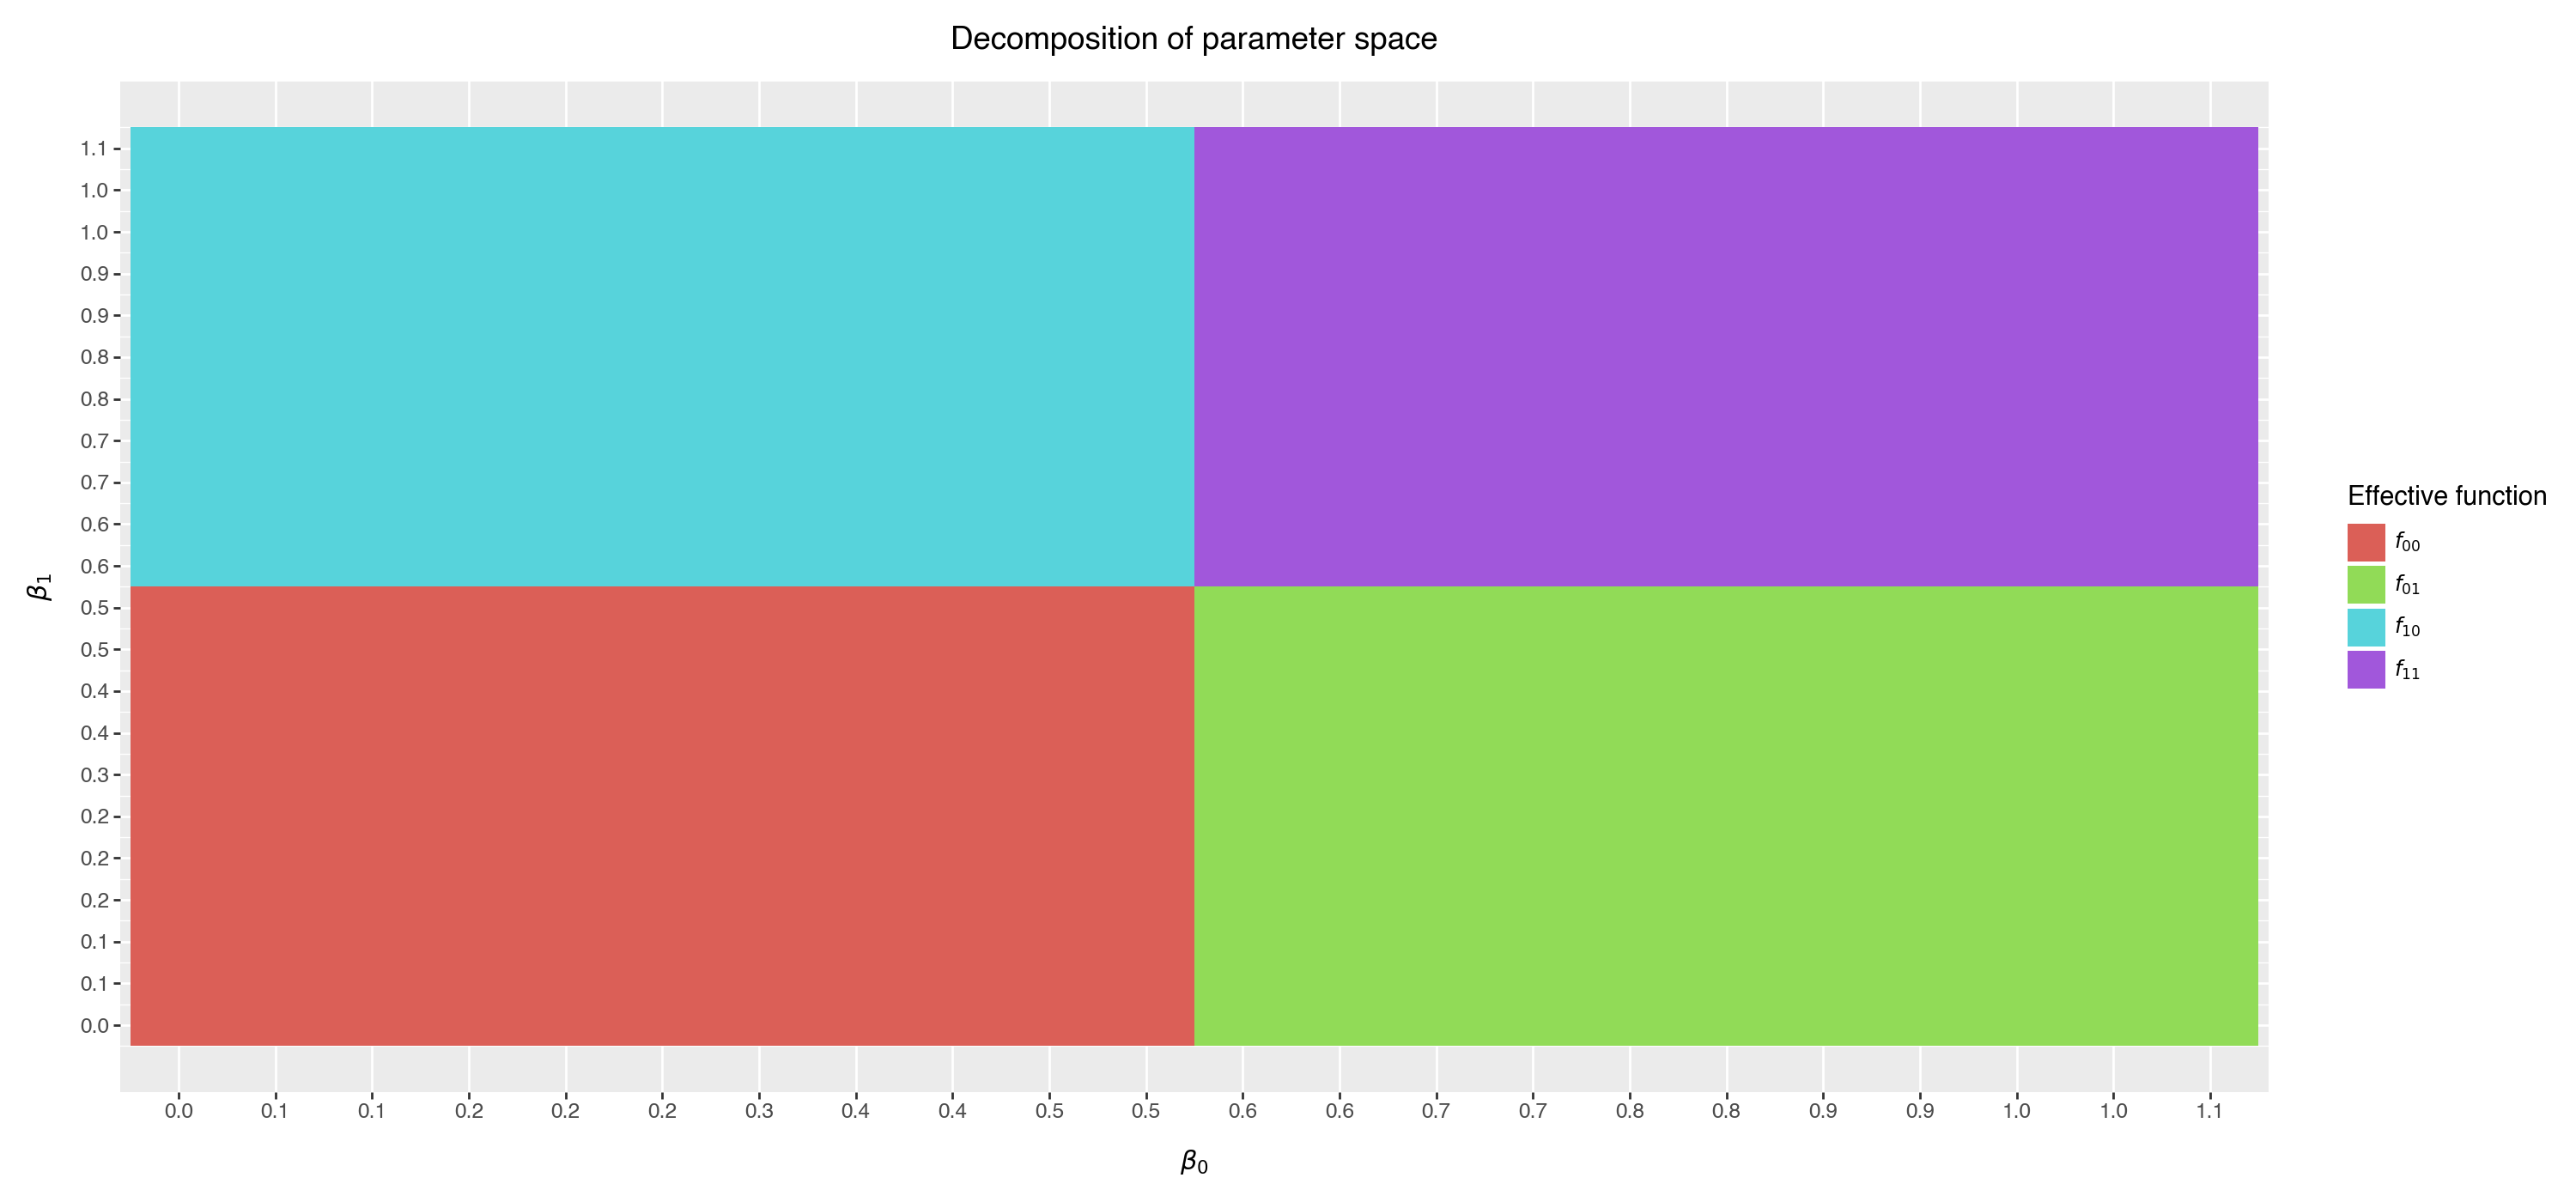

In [22]:
beta0 = np.arange(0.0, 1.1, 0.05)
beta1 = np.arange(0.0, 1.1, 0.05)
ftype = np.full(shape=(len(beta0), len(beta1)), fill_value='xxxxxxxx')

for i in range(len(beta0)):
    for j in range(len(beta1)):
        fout = np.round(beta0[i] * np.array([1,0]) + beta1[j] * np.array([0, 1])).astype(int) 
        ftype[i][j] = '$f_{' + ''.join(str(x) for x in fout) + '}$'

sdf = DataFrame(ftype)
sdf = sdf.reset_index().melt('index')

p  = ggplot(sdf)
p += geom_tile(aes(x='variable', y='index', fill='value'))
p += scale_x_discrete(breaks=list(range(len(beta0))), labels=[f'{x:.1f}' for x in beta0]) 
p += scale_y_continuous(breaks=list(range(len(beta1))), labels=[f'{x:.1f}' for x in beta1]) 
p += labs(x=r'$\beta_0$', y=r'$\beta_1$', fill='Effective function')
p += ggtitle('Decomposition of parameter space')
display(p)

**Judgement:** Altough the parameter space is infinite and gradient search makes a complex path during training the search actually touches only a finite number of functions. The upper limit to different functions is the number of steps (linearly realted to epochs). 

For continious prediction tasks, the number of equivalent functions can remain infinite. However, we can bypass this problem by considering only a predictions on an independently sampled $m$-element test set. Then the number of functions becomes finite again and the question becomes what is the typical number of distinct functions possible on the $m$-element test set. Statistical learning theory is very much interested in this question as it allows to bound the distance between test and training error.

## VI. Bayes-optimal solution for a three-dimensional case with biased coin

The analyis of higher-dimensional cases is analogous to one-dimensional case except the number of functions becomes larger and the number of **parallel prediction intervals** grows exponentially. Nevertheless, it is instructive to study three-dimensional case in detail, as it shows why **early stopping** could reduce the over-fitting. 

In [23]:
def true_risk_2(yp, alpha=0.5):
    """
    Computes true risk on the prediction vector. Makes it simpler to draw the graphs.
    Bias alpha is the probability that the true answer is 1 for any prediction.
    """
    # This is just a covoluted way to express that prediction is wrong for f(i) 
    return sum(alpha**(1 - yp[i])*(1 - alpha)**(yp[i]) for i in range(len(yp)))/len(yp)

print(f'The best function f11 achieves risk {true_risk_2([1, 1], alpha=0.9):0.1f} as expected')

The best function f11 achieves risk 0.1 as expected


Lets evaluate the true riks value on 256 possible functions.

In [24]:
alpha = 0.55
borders = DataFrame({'fun_index': [f'{i:08b}' for i in  range(256)]})
borders['function'] = '$f_{' + borders['fun_index'] +'}$'
borders['true_risk'] = borders['fun_index'].map(lambda x: round(true_risk_2([int(xi) for xi in x], alpha), 3))
borders['p025'] = borders['true_risk'].map(lambda x: prediction_interval_for_biased_coin(n, x, prob=0.95)[0])
borders['p975'] = borders['true_risk'].map(lambda x: prediction_interval_for_biased_coin(n, x, prob=0.95)[1])
borders['p001'] = borders['true_risk'].map(lambda x: prediction_interval_for_biased_coin(n, x, prob=0.998)[0])
borders['p999'] = borders['true_risk'].map(lambda x: prediction_interval_for_biased_coin(n, x, prob=0.998)[1])
borders = borders.sort_values(by=['true_risk', 'fun_index'], ascending=[False, True])
borders['function'] = pd.Categorical(borders['function'], categories=borders['function'], ordered=True)

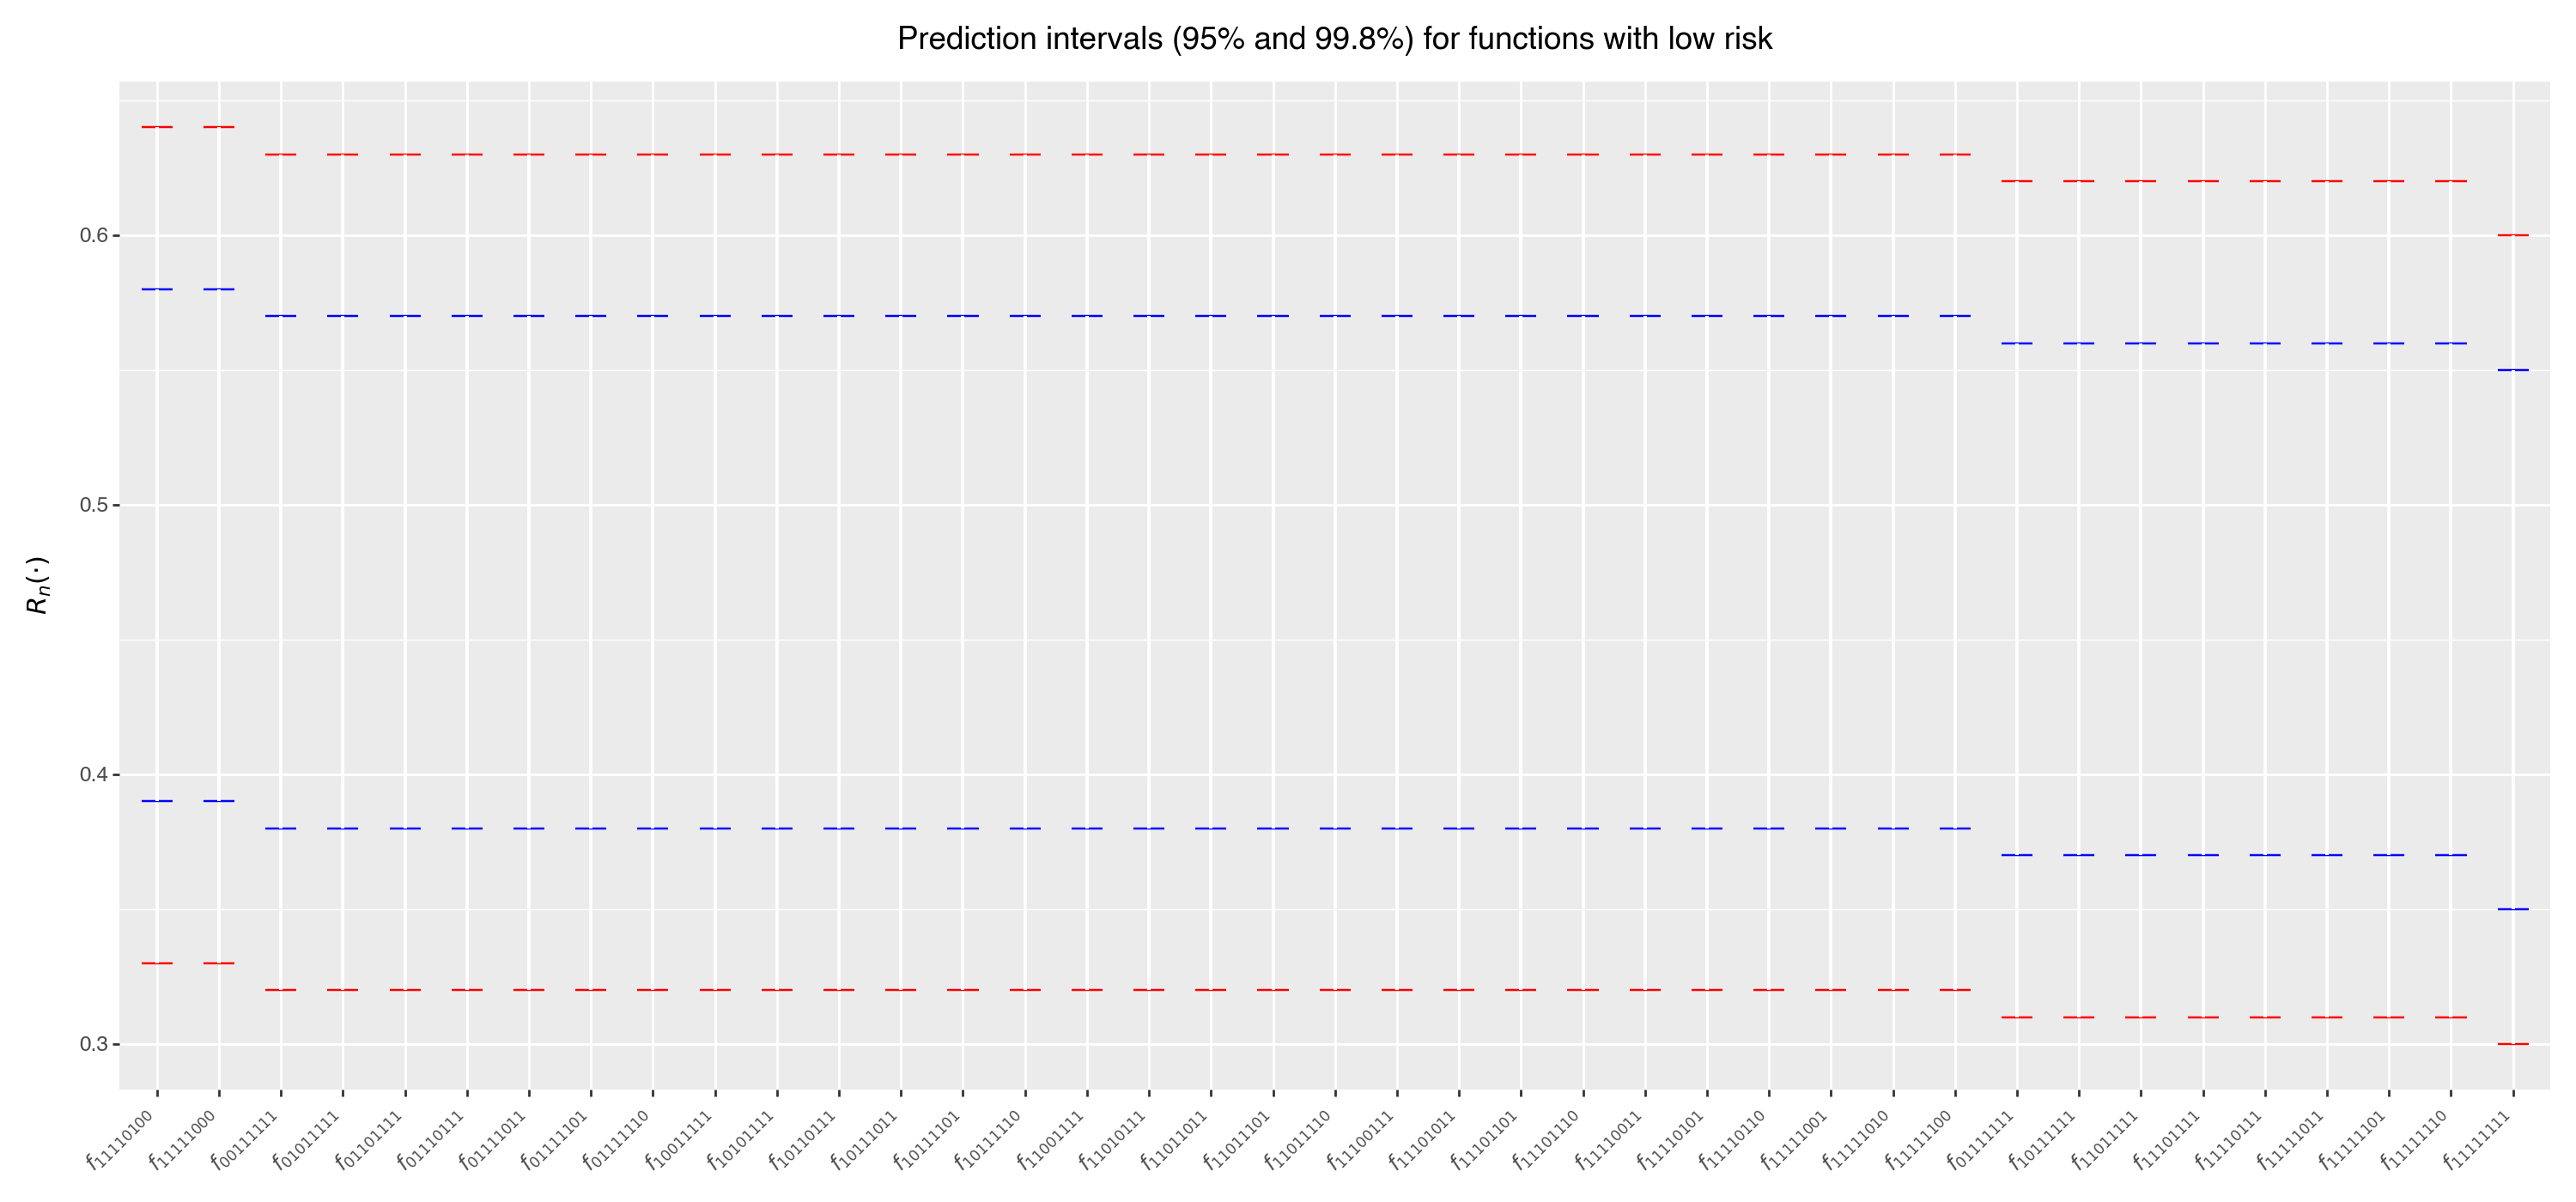

In [25]:
p  = ggplot(borders[217:])
p += geom_errorbar(aes(x='function',  ymin='p001', ymax='p999'),  color='red', linetype='solid')
p += geom_linerange(aes(x='function',  ymin='p001', ymax='p999'),  color='white', linetype='solid', size=0.8)
p += geom_errorbar(aes(x='function',  ymin='p025', ymax='p975'),  color='blue', linetype='solid')
p += geom_linerange(aes(x='function',  ymin='p025', ymax='p975'),  color='white', linetype='solid',size=0.8)
p += xlab('') + ylab('$R_n(\cdot)$')
p += theme(axis_text_x=element_text(angle=45, hjust=1))
p += ggtitle('Prediction intervals (95% and 99.8%) for functions with low risk')
display(p)

**Judgements:**
* Note that the difference between 95% prediction intervals is not large for functions with low true risk.
* As there are much more near-optimal functions than the optimal functions, the function with minimal empirical risk will be near-optimal for most generated datasets. Thus the last steps in gradient decent that pick up the function with the lowest empirical risk do nothing sensible as there is not enough data in empirical risks.

### Early stopping algorithm

Let us consider a modification of gradient descent algorithm that uses separate test set to evaluate empirical risk at the end of each epoch and chooses the one with lowest test error:
* This makes choice between different functions explicit. If there can be $k$ epcochs then the algorithm performs $k$ parallel tests. This number might be much smaller than the number of implicit tests done during gradient search.
* The last function can have higher risk than functions tested in the middle. Our example shows, that near-optimal functions can have low empirical risk. As the number functions such that $R(f)\leq R(f_*)+\varepsilon$ usually increases exponentially when $\varepsilon$ grows and thus the function with the miminal empirical risk can have much bigger training error than functions with a low training error and early stopping based on test error weeds out problematic functions.
